In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.plotting import adjust_plot_1d

In [28]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

def get_gcd(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, -6]/scale, results[:, -5]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

def get_zen_azi(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, -6]/scale, results[:, -5]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    return track_src_v[:, 0], track_src_v[:, 1], reco_zenith, reco_azimuth, smpe_zenith, smpe_azimuth

def get_hist(results):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
    print(np.amax(gcd), np.amax(gcd_smpe))
    print(np.median(gcd), np.median(gcd_smpe))
    bins = np.linspace(0.0, 3.0, 41)
    cts, _ = np.histogram(gcd, bins=bins)
    cts_smpe, _ = np.histogram(gcd_smpe, bins=bins)
    return cts, bins, cts_smpe

def get_percentiles(results):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
    ps = np.percentile(gcd, [16, 50, 84])
    ps_smpe = np.percentile(gcd_smpe, [16, 50, 84])
    return ps, ps_smpe

In [146]:
dat = np.load('/home/storage/hans/jax_reco_new/examples/reco_realtime/results/reco_result_20027_tfrecord.npy')

In [147]:
TPN_MPE, bins, S_MPE = get_hist(dat)
true_zen, true_azi, reco_zen, reco_azi, smpe_zen, smpe_azi = get_zen_azi(dat)

0.3003764893128606 0.24855303531490852
0.08814138881254005 0.10727373382087824


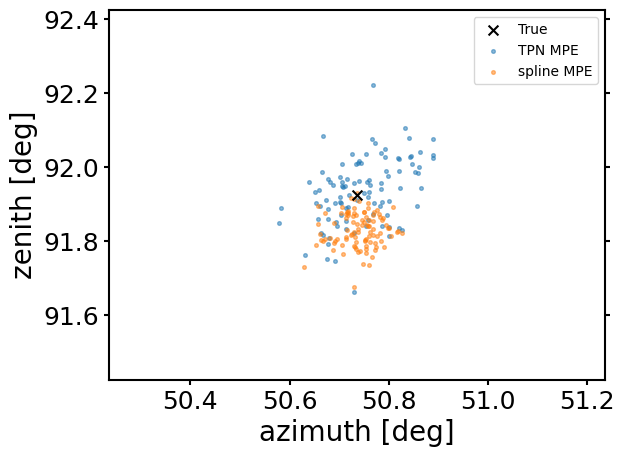

In [148]:
fig, ax = plt.subplots()
plt.scatter(np.rad2deg(true_azi)[0:1], np.rad2deg(true_zen)[0:1], marker='x', color='black', label='True', s=50, zorder=5)
plt.scatter(np.rad2deg(reco_azi), np.rad2deg(reco_zen), label='TPN MPE', s=7, color='tab:blue', alpha=0.5)
plt.scatter(np.rad2deg(smpe_azi), np.rad2deg(smpe_zen), label='spline MPE', s=7, color='tab:orange', alpha=0.5)

plt.legend()
d_zen = 0.5
plt.xlim()
plt.ylim()

plot_args = {'xlabel':'azimuth [deg]', 
                 'ylabel':'zenith [deg]', 
                 'xlim':[np.rad2deg(true_azi[0])-d_zen, np.rad2deg(true_azi[0])+d_zen], 
                 'ylim':[np.rad2deg(true_zen[0])-d_zen, np.rad2deg(true_zen[0])+d_zen]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

In [64]:
import glob
fs = glob.glob('/home/storage/hans/jax_reco_new/examples/reco_realtime/results/*.npy')

tpn_mpe_v = []
s_mpe_v = []

for f in fs:
    dat = np.load(f)
    tpn_mpe, s_mpe = get_percentiles(dat)
    tpn_mpe_v.append(tpn_mpe)
    s_mpe_v.append(s_mpe)

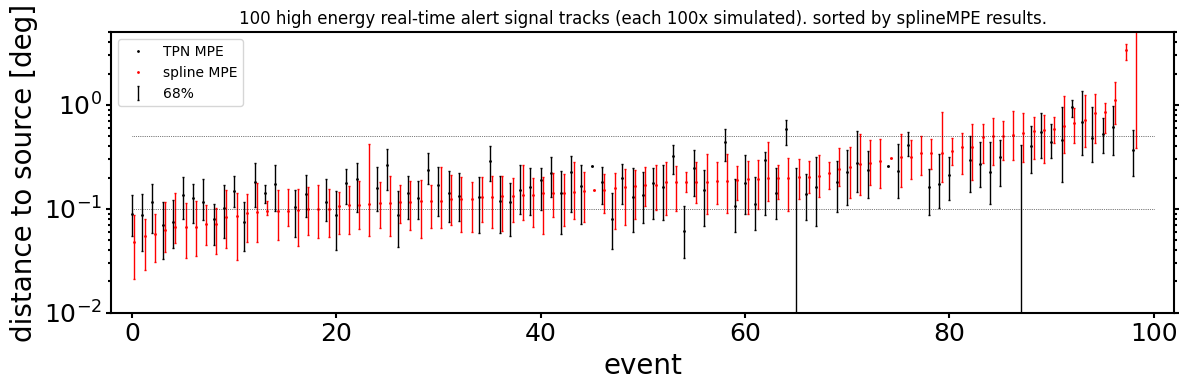

In [149]:
fig, ax = plt.subplots(figsize=(12,4))
x = np.array(list(range(99)))

y = np.array([t[1] for t in tpn_mpe_v])
z = np.array([t[1] for t in s_mpe_v])

idx = np.argsort(z)
z = z[idx]
y = y[idx]
y_err_up = np.array([t[2] for t in tpn_mpe_v])[idx] - y
y_err_low = y - np.array([t[0] for t in tpn_mpe_v])[idx]

#y_err_up = np.array([t[2] for t in tpn_mpe_v]) - y
#y_err_low = y - np.array([t[0] for t in tpn_mpe_v])


z_err_up = np.array([t[2] for t in s_mpe_v])[idx] - z
z_err_low = z - np.array([t[0] for t in s_mpe_v])[idx]

#z = np.array([t[1] for t in s_mpe_v])
#z_err_up = np.array([t[2] for t in s_mpe_v]) - z
#z_err_low = z - np.array([t[0] for t in s_mpe_v])

ax.errorbar(x, y, yerr=[y_err_low, y_err_up], capsize=1, linewidth=0, elinewidth=1, color='black', label='68%')
ax.plot(x, y, "ko", markersize=1, label='TPN MPE')

dx = 0.25 * (x[1:] - x[:-1])
dx = np.concatenate([dx, np.array([dx[-1]])])
ax.errorbar(x+dx, z, yerr=[z_err_low, z_err_up], capsize=1, linewidth=0, elinewidth=1, color='red')
ax.plot(x+dx, z, "ro", markersize=1, label='spline MPE')
ax.set_yscale('log')
ax.plot([0.0, 100.0], [0.5, 0.5], linestyle='dotted', lw=0.5, color='k')
ax.plot([0.0, 100.0], [0.1, 0.1], linestyle='dotted', lw=0.5, color='k')

plot_args = {'xlabel':'event', 
                 'ylabel':'distance to source [deg]', 
                 'xlim':[-2.0, 102], 
                 'ylim':[0.01, 5]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_title("100 high energy real-time alert signal tracks (each 100x simulated). sorted by splineMPE results.")
plt.tight_layout()
plt.show()

/tmp/ipykernel_12112/1995518661.py:2: RuntimeWarning: divide by zero encountered in divide
  ax.plot(x, z/y, "ro", markersize=3, alpha=0.5, label='splineMPE / TPN MPE')


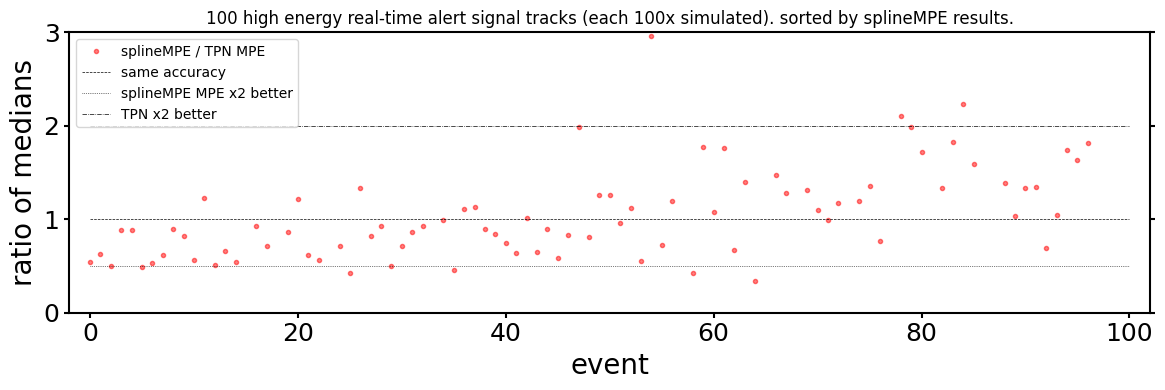

In [133]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x, z/y, "ro", markersize=3, alpha=0.5, label='splineMPE / TPN MPE')
ax.plot([0.0, 100.0], [1.0, 1.0], linestyle='dashed', color='k', lw=0.5, label='same accuracy')
ax.plot([0.0, 100.0], [0.5, 0.5], linestyle='dotted', color='k', lw=0.5, label='splineMPE MPE x2 better')
ax.plot([0.0, 100.0], [2.0, 2.0], linestyle='dashdot', color='k', lw=0.5, label='TPN x2 better')
plot_args = {'xlabel':'event', 
                 'ylabel':'ratio of medians', 
                 'xlim':[-2.0, 102], 
                 'ylim':[0.0, 3.0]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_title("100 high energy real-time alert signal tracks (each 100x simulated). sorted by splineMPE results.")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()